- https://future-chem.com/rdkit-conformer/
- https://greglandrum.github.io/rdkit-blog/posts/2023-02-04-working-with-conformers.html

In [6]:
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, Draw, PandasTools
from rdkit.Chem.Draw import IPythonConsole
import sys, py3Dmol
import pandas as pd
print(sys.version)

print(rdBase.rdkitVersion)

3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]
2023.09.5


In [2]:
df = pd.read_csv("/Users/lpc_0066/Desktop/Dataset/その他/Volume of Distribution/VDss_dataset_uen.csv")

Generate mol column by PandasTools

In [3]:
PandasTools.AddMoleculeColumnToFrame(df, molCol='mols', smilesCol='SMILES')
df.head(10)

,SMILES,MW,logP,VDss(L/kg),logVDss,mols
0,CC(C)N(CCC(c1ccccc1)c1cc(CO)ccc1O)C(C)C,341.495,4.52530,2.41,0.382017,<rdkit.Chem.rdchem.Mol object at 0x1752b5af0>
1,O=C(OC1C[N+]2(CCCOc3ccccc3)CCC1CC2)C(O)(c1cccs...,484.663,4.66680,4.30,0.633468,<rdkit.Chem.rdchem.Mol object at 0x1752b5c40>
2,CC[C@H]1C2C[C@H]3[C@@H]4N(C)c5ccccc5[C@]45C[C@...,326.440,1.55450,4.00,0.602060,<rdkit.Chem.rdchem.Mol object at 0x1752b5cb0>
3,C=CC[N+]12CCC34c5ccccc5N5/C=C6/C7CC8C9(CC[N+]8...,666.910,5.47560,0.32,-0.494850,<rdkit.Chem.rdchem.Mol object at 0x1752b5d20>
4,CCCS(=O)CCCN(CC)CC(O)COc1ccc(C#N)cc1,352.500,2.16868,1.80,0.255273,<rdkit.Chem.rdchem.Mol object at 0x1752b5d90>
5,CNC(=O)C(c1ccccc1)N1CCc2cc(OC)c(OC)cc2C1CCc1cc...,512.572,5.74190,9.75,0.989005,<rdkit.Chem.rdchem.Mol object at 0x1752b5e00>
6,C=CCN1CCCC1CNC(=O)c1cc(S(=O)(=O)NC)c(N)cc1OC,382.486,0.56570,2.30,0.361728,<rdkit.Chem.rdchem.Mol object at 0x1752b5e70>
7,CCCCCC(O)/C=C/C1C(O)CC(=O)C1CCCCCCC(=O)O,354.487,3.47510,2.40,0.380211,<rdkit.Chem.rdchem.Mol object at 0x1752b5ee0>
8,CCNC(=O)C1CC(n2ccc3c(NC(CC)Cc4sccc4Cl)ncnc32)C...,478.018,2.99830,0.84,-0.075721,<rdkit.Chem.rdchem.Mol object at 0x1752b5f50>
9,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...,457.432,-3.10802,0.21,-0.677781,<rdkit.Chem.rdchem.Mol object at 0x1752b5fc0>


Add Hydrogen to the structure(important!)

In [4]:
m = df.mols[0]
m_h = Chem.AddHs(m)
# df.mols = df.mols.apply(lambda x: Chem.AddHs(x))

In [5]:
numConfs = 100
rms = [0.1, 0.5, 1.0, 1.5, 2.0]
num_of_confs = []

for i in rms:
    confids = AllChem.EmbedMultipleConfs(m_h, numConfs=numConfs, randomSeed=1234, pruneRmsThresh=i, numThreads=0)
    num_of_confs.append((i, len(confids)))

# "EmbedMultipleConfs" only returns list of new conformation IDs
# It was said that if there are many rotatable bonds, a higher threshold is needed to have fewer distinct conformers.

pd.DataFrame(num_of_confs, columns=["threshold", "conformers"])

,threshold,conformers
0,0.1,98
1,0.5,63
2,1.0,8
3,1.5,2
4,2.0,1


Comparing energy difference before and after optimization

In [6]:
"""The energy difference of SINGLE conformer."""

m = df.mols[0]
m_h = Chem.AddHs(m)

print(m_h.GetNumConformers())

# Generate initial structure
AllChem.EmbedMolecule(m_h)

# Calculate initial energy
ff = AllChem.UFFGetMoleculeForceField(m_h)
initial_energy = ff.CalcEnergy()

# Optimize the structure
AllChem.UFFOptimizeMolecule(m_h)

# Calculate optimized energy
optimized_energy = ff.CalcEnergy()

print(f"Initial Energy: {initial_energy:.2f} kcal/mol")
print(f"Optimized Energy: {optimized_energy:.2f} kcal/mol")

0
Initial Energy: 201.27 kcal/mol
Optimized Energy: 181.79 kcal/mol


In [5]:
"""The energy difference of MULTIPLE conformers."""

m = df.mols[0]

def eval_optimization(m, ff):
    m_h = Chem.AddHs(m)

    cids = AllChem.EmbedMultipleConfs(m_h, numConfs=10, randomSeed=1234, pruneRmsThresh=0.1, numThreads=0)
    print(m_h.GetNumConformers())

    # Calculate initial energy
    initial_energy = []
    optimized_energy = []

    if ff == 'uff':
        for cid in cids:
            uff = AllChem.UFFGetMoleculeForceField(m_h, confId=cid)
            initial_energy.append((cid, uff.CalcEnergy()))
            uff.Minimize()
            optimized_energy.append((cid, uff.CalcEnergy()))
    if ff == 'mmff':
        prop = AllChem.MMFFGetMoleculeProperties(m_h)
        for cid in cids:
            mmff = AllChem.MMFFGetMoleculeForceField(m_h, prop, confId=cid)
            initial_energy.append((cid, mmff.CalcEnergy()))
            mmff.Minimize()
            optimized_energy.append((cid, mmff.CalcEnergy()))

    ini_df = pd.DataFrame(initial_energy, columns=["energy", "ID"])
    opt_df = pd.DataFrame(optimized_energy, columns=["energy", "ID"])
    print(f"The energy of initial structure of conformers by {ff}")
    display(ini_df)
    print("")
    print(f"The energy of optimized structure of conformers by {ff}")
    display(opt_df)

In [6]:
eval_optimization(m, 'uff')

10
The energy of initial structure of conformers by uff


,energy,ID
0,0,181.540379
1,1,136.497640
2,2,124.156043
3,3,154.382968
4,4,176.714458
5,5,147.035103
6,6,180.114057
7,7,141.092883
8,8,150.466786
9,9,197.034662



The energy of optimized structure of conformers by uff


,energy,ID
0,0,64.306122
1,1,70.944422
2,2,58.383696
3,3,69.809209
4,4,69.145436
5,5,63.782167
6,6,73.684346
7,7,68.787118
8,8,67.158431
9,9,62.400490


In [7]:
eval_optimization(m, 'mmff')

10
The energy of initial structure of conformers by mmff


,energy,ID
0,0,130.458567
1,1,102.780866
2,2,109.956777
3,3,113.245099
4,4,133.096960
5,5,107.665340
6,6,130.198018
7,7,103.774668
8,8,113.766011
9,9,146.615632



The energy of optimized structure of conformers by mmff


,energy,ID
0,0,55.711858
1,1,60.445945
2,2,56.771711
3,3,60.947262
4,4,61.272431
5,5,55.543891
6,6,58.842397
7,7,59.091888
8,8,61.672024
9,9,56.510229


Conformer Alignment

In [4]:
from rdkit import Chem
from rdkit.Chem import AllChem
import py3Dmol
from rdkit.Chem.Draw import IPythonConsole

mol = Chem.MolFromSmiles('NC(=[NH2+])c1ccc(C[C@@H](NC(=O)CNS(=O)(=O)c2ccc3ccccc3c2)C(=O)N2CCCCC2)cc1')
m_h = Chem.AddHs(mol)
cids = AllChem.EmbedMultipleConfs(m_h, numConfs=50, maxAttempts=1000, pruneRmsThresh=0.1)

# List up energy and conformer ID set
energy = []
for cid in cids:
    uff = AllChem.UFFGetMoleculeForceField(m_h, confId=cid)
    uff.Minimize()
    energy.append((uff.CalcEnergy(), cid))
energy.sort()

# To derive 5 most stable(lowest energy) structure
uff_cids = [j for i,j in energy[:5]]
opt = Chem.RemoveHs(m_h)

# Load benzene as template to derive partial postion
core = m_h.GetSubstructMatch(Chem.MolFromSmiles('C1=CC=CC=C1'))

# Align the conformers
rmslist = []
AllChem.AlignMolConformers(opt, atomIds=core, RMSlist=rmslist)
v = py3Dmol.view(width=600, height=600)
for cid in cids[:5]:
    IPythonConsole.addMolToView(opt, confId=cid, view=v)
v.setBackgroundColor('0xeeeeee')
v.zoomTo()
v.show()

# The top lowest energy conformer is overlaped on benzene.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

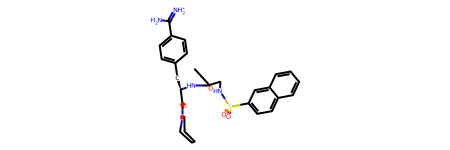

In [5]:
opt

Get Conformer information

In [6]:
conf = opt.GetConformer(0)

In [11]:
opt.GetNumAtoms()

37

In [12]:
conf.GetPositions().shape, conf.GetPositions()

((37, 3),
 array([[-4.55846616,  6.16574366, -1.40943562],
        [-3.70587017,  6.04277964, -0.26423692],
        [-3.11241185,  7.09959366,  0.20740283],
        [-3.50234815,  4.71677458,  0.36872934],
        [-4.57204752,  3.81054869,  0.47046934],
        [-4.3872195 ,  2.55851407,  1.06368038],
        [-3.13168009,  2.19318142,  1.57301679],
        [-2.93267419,  0.83573168,  2.19981811],
        [-2.63330278, -0.24273923,  1.13523678],
        [-1.45811484,  0.12556958,  0.33676315],
        [-0.11088127,  0.13207336,  0.83328083],
        [ 0.13192399, -0.13319154,  2.04117384],
        [ 1.01563453,  0.48205939, -0.08655192],
        [ 0.98563016, -0.38923661, -1.26542292],
        [ 1.90562884, -1.84391442, -0.99954348],
        [ 1.35099266, -2.55778311,  0.20180316],
        [ 1.76458339, -2.73036682, -2.20314188],
        [ 3.62219982, -1.51415711, -0.73669844],
        [ 4.41980238, -2.48209236, -0.10816066],
        [ 5.77511891, -2.23824756,  0.12982004],
        [ 

In [13]:
confs = opt.GetConformers()

In [16]:
c = confs[0]

In [18]:
c.GetPositions().shape, c.GetPositions()

((37, 3),
 array([[-4.55846616,  6.16574366, -1.40943562],
        [-3.70587017,  6.04277964, -0.26423692],
        [-3.11241185,  7.09959366,  0.20740283],
        [-3.50234815,  4.71677458,  0.36872934],
        [-4.57204752,  3.81054869,  0.47046934],
        [-4.3872195 ,  2.55851407,  1.06368038],
        [-3.13168009,  2.19318142,  1.57301679],
        [-2.93267419,  0.83573168,  2.19981811],
        [-2.63330278, -0.24273923,  1.13523678],
        [-1.45811484,  0.12556958,  0.33676315],
        [-0.11088127,  0.13207336,  0.83328083],
        [ 0.13192399, -0.13319154,  2.04117384],
        [ 1.01563453,  0.48205939, -0.08655192],
        [ 0.98563016, -0.38923661, -1.26542292],
        [ 1.90562884, -1.84391442, -0.99954348],
        [ 1.35099266, -2.55778311,  0.20180316],
        [ 1.76458339, -2.73036682, -2.20314188],
        [ 3.62219982, -1.51415711, -0.73669844],
        [ 4.41980238, -2.48209236, -0.10816066],
        [ 5.77511891, -2.23824756,  0.12982004],
        [ 